#  Heart failure prediction

## Imports

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

# matplotlib adjustments
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# constants
PROJECT_ROOT_DIR = "."
HEART_PATH = os.path.join("data")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

In [2]:
def load_heart_data(heart_path=HEART_PATH):
    csv_path = os.path.join(heart_path, "heart.csv")
    return pd.read_csv(csv_path)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Exploratory Data Engineering

In [3]:
heart_data = load_heart_data()
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Save dataframe as image
#import dataframe_image as dfi
#dfi.export(heart_data.head(),"images/data_sample.png")

In [5]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Plotting Numerical and Categorial Features

In [7]:
numeric_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "FastingBS"]
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

Saving figure bar_cat


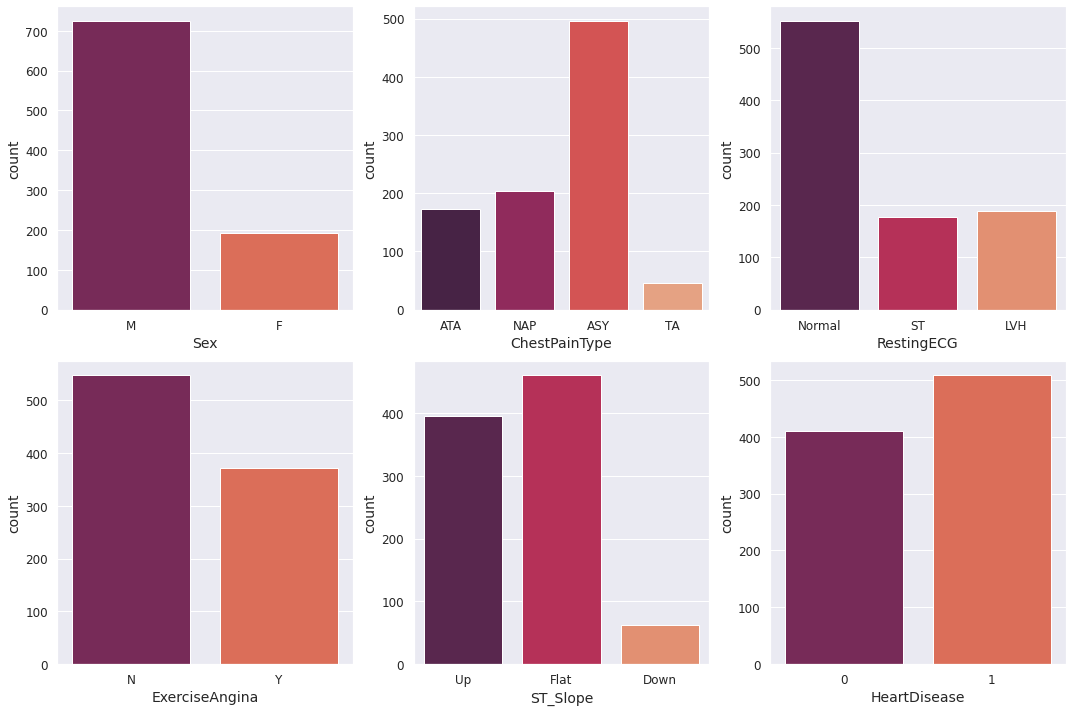

In [8]:
f, axes = plt.subplots(2, 3, figsize=(15, 10))

for i,k in enumerate(categorical_features + ['HeartDisease']):
    sns.countplot(x = heart_data[k], data = heart_data, palette='rocket', ax = axes.flat[i])
save_fig("bar_cat")
plt.show()


Saving figure bar_num


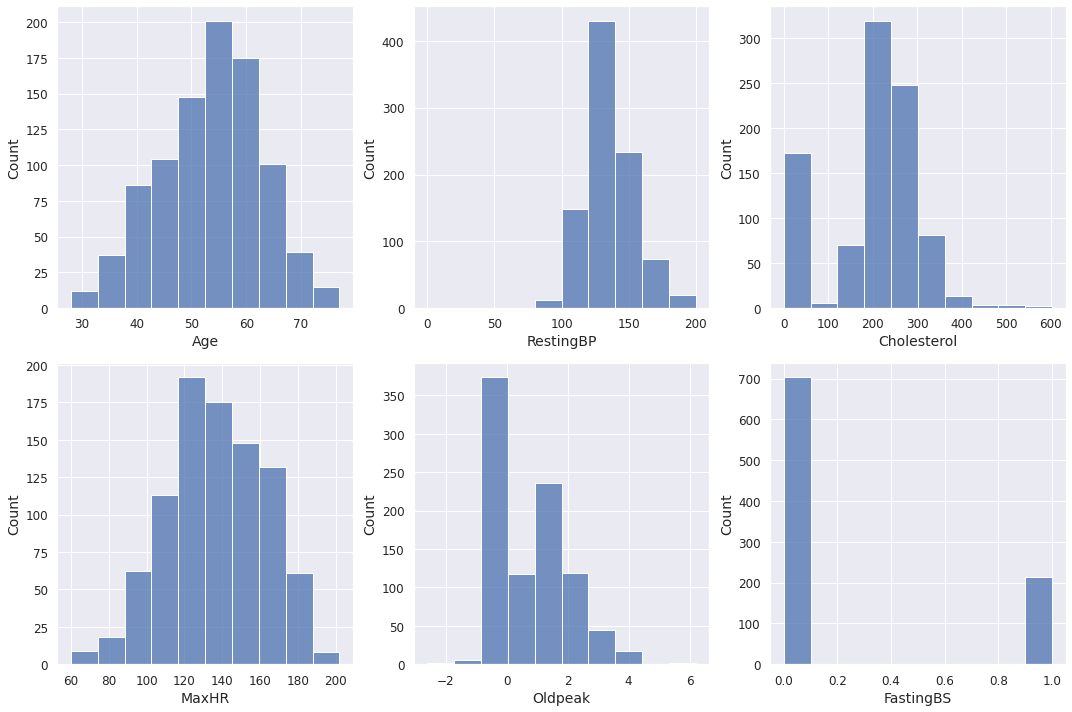

In [9]:
f, axes = plt.subplots(2, 3, figsize=(15, 10))

for i,k in enumerate([x for x in numeric_features]):
    cat = heart_data[k].unique()
    sns.histplot(x = heart_data[k], data = heart_data[k], palette='rocket', ax = axes.flat[i], bins=10)
save_fig("bar_num")
plt.show()

In [10]:
heart_num = heart_data[numeric_features]
heart_cat = heart_data[categorical_features]

In [11]:
heart_with_dummy_values = pd.get_dummies(heart_data, columns = categorical_features )

plt.figure(figsize=(20, 10))
corr = heart_with_dummy_values.corr()

<Figure size 1440x720 with 0 Axes>

Saving figure bar_corr


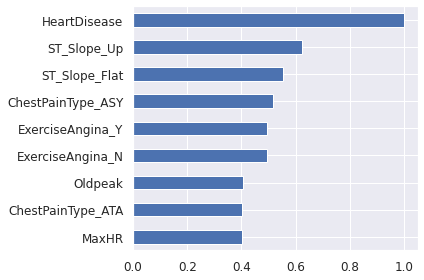

In [12]:
f, axes = plt.subplots(1, 1)# figsize=(15, 10))
sorted_corr = corr['HeartDisease'].apply(lambda x: abs(x)).sort_values(ascending=True)
sorted_corr_filtered = sorted_corr[sorted_corr.gt(.4)]
sorted_corr_filtered.plot.barh()
save_fig("bar_corr")
plt.show()

## Generate Data Pipeline

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder( handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Test and Training Split

In [14]:
X = heart_data.drop('HeartDisease', axis=1)
y = (heart_data['HeartDisease']).apply(lambda x: bool(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = y_train.apply(lambda x: bool(x))


In [15]:
X_train_prepared = preprocessor.fit_transform(X_train)

### Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

transformed_column_names = list(preprocessor.transformers_[1][1].get_feature_names(categorical_features))

clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train_prepared, y_train)
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=numeric_features + transformed_column_names,  
                     class_names=["Heart Desease", "No Heart Desease"],
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render('images/tree', format='png')

'images/tree.png'

In [17]:
from sklearn.metrics import precision_recall_fscore_support as score

X_test_prepared = preprocessor.transform(X_test)
predicted = clf.predict(X_test_prepared)

#, recall, fscore, support = score(y_test, predicted)
precision = precision_score(y_pred = predicted, y_true = y_test)
accuracy = accuracy_score(y_pred = predicted, y_true = y_test)
recall = recall_score(y_pred = predicted, y_true = y_test)
f1score = f1_score(y_pred = predicted, y_true = y_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('accuracy: {}'.format(accuracy))
print('f1_score: {}'.format(f1score))
#print('support: {}'.format(support))

precision: 0.794392523364486
recall: 0.794392523364486
accuracy: 0.7608695652173914
f1_score: 0.794392523364486


### Neural Network

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

# Define Tensorboard as a Keras callback
tensorboard = TensorBoard(
  histogram_freq=1,
  write_images=True
)
early_stopping = EarlyStopping(patience=1)

model = keras.models.Sequential([
    keras.layers.Dense(50,  activation="relu", kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)),
    keras.layers.Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)),
    keras.layers.Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.01),
            activity_regularizer=regularizers.l1(0.01)),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer="adam")

n_epochs = 250

history = model.fit(X_train_prepared, y_train, epochs=n_epochs, validation_split=0.25, 
                    callbacks=[early_stopping, tensorboard])

2021-12-09 10:38:01.654364: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-09 10:38:01.654397: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-09 10:38:01.654798: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-09 10:38:01.665027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 10:38:01.666777: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-12-09 10:38:01.739088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] Non

Epoch 1/250
12/18 [===================>..........] - ETA: 0s - loss: 2.6188

2021-12-09 10:38:03.136262: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-09 10:38:03.136292: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-09 10:38:03.142349: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-09 10:38:03.144487: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-09 10:38:03.146990: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2021_12_09_10_38_03

2021-12-09 10:38:03.148362: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_12_09_10_38_03/T14s.trace.json.gz
2021-12-09 10:38:03.154886: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2021_12_09_10_38_03

2021-12-09 10:38:03.161389: I tensorf

18/18 [==============================] - 2s 50ms/step - loss: 2.5568 - val_loss: 2.3346
Epoch 2/250
18/18 [==============================] - 0s 12ms/step - loss: 2.1878 - val_loss: 2.0180
Epoch 3/250
18/18 [==============================] - 0s 10ms/step - loss: 1.8925 - val_loss: 1.7492
Epoch 4/250
18/18 [==============================] - 0s 9ms/step - loss: 1.6374 - val_loss: 1.5103
Epoch 5/250
18/18 [==============================] - 0s 10ms/step - loss: 1.4059 - val_loss: 1.3001
Epoch 6/250
18/18 [==============================] - 0s 10ms/step - loss: 1.2127 - val_loss: 1.1433
Epoch 7/250
18/18 [==============================] - 0s 8ms/step - loss: 1.0620 - val_loss: 1.0248
Epoch 8/250
18/18 [==============================] - 0s 9ms/step - loss: 0.9481 - val_loss: 0.9328
Epoch 9/250
18/18 [==============================] - 0s 10ms/step - loss: 0.8595 - val_loss: 0.8584
Epoch 10/250
18/18 [==============================] - 0s 12ms/step - loss: 0.7928 - val_loss: 0.8015
Epoch 11/250
1

In [19]:
tf_predicted = np.round(model.predict(X_test_prepared)).astype(np.int64)

precision = precision_score(y_pred = tf_predicted, y_true = y_test)
accuracy = accuracy_score(y_pred = tf_predicted, y_true = y_test)
recall = recall_score(y_pred = tf_predicted, y_true = y_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('accuracy: {}'.format(accuracy))
print('f1_score: {}'.format(f1score))

precision: 0.8448275862068966
recall: 0.9158878504672897
accuracy: 0.8532608695652174
f1_score: 0.794392523364486


In [20]:
%load_ext tensorboard
%tensorboard --logdir logs/

## XG Boost

In [21]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

xg_clf = xgb.XGBClassifier(eta=0.3, max_depth=20, gamma=0.0)
xg_clf.fit(X_train_prepared, y_train)

/home/michael/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:38:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
xgb_predicted = xg_clf.predict(X_test_prepared)
accuracy = accuracy_score(y_pred = xgb_predicted, y_true = y_test)
recall = recall_score(y_pred = xgb_predicted, y_true = y_test)

precision = precision_score(y_pred = xgb_predicted, y_true = y_test)
f1=f1_score(y_pred = xgb_predicted, y_true = y_test)

print(accuracy)
print(precision)
print(recall)
print(f1)

0.8586956521739131
0.8584070796460177
0.9065420560747663
0.8818181818181818


### Support Vector Machine

In [23]:
from sklearn.svm import SVC
svm = SVC(gamma='scale')
svm.fit(X_train_prepared, y_train)

SVC()

In [24]:
svm_predicted = svm.predict(X_test_prepared)
accuracy = accuracy_score(y_pred = svm_predicted, y_true = y_test)
precision = precision_score(y_pred = svm_predicted, y_true = y_test)
recall = recall_score(y_pred = svm_predicted, y_true = y_test)
f1=f1_score(y_pred = svm_predicted, y_true = y_test)

print(accuracy)
print(precision)
print(recall)
print(f1)

0.8478260869565217
0.8495575221238938
0.897196261682243
0.8727272727272727


## Evaluate Neural Network

Saving figure confusion_matrix_tf


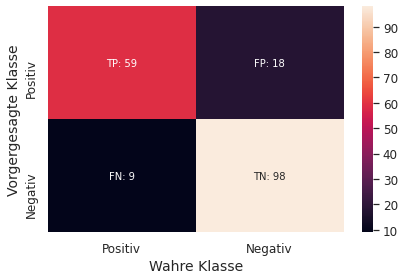

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#plt.figure(figsize=(15,8))
tf_confusion_matrix =  confusion_matrix(y_test, tf_predicted)
ax = sns.heatmap(tf_confusion_matrix, annot=True)
ax.set_xticklabels(('Positiv', 'Negativ'))
ax.set_yticklabels(('Positiv', 'Negativ'))
plt.xlabel('Wahre Klasse')
plt.ylabel('Vorgergesagte Klasse')
ax.texts[0].set_text('TP: ' + ax.texts[0].get_text())
ax.texts[1].set_text('FP: ' + ax.texts[1].get_text())
ax.texts[2].set_text('FN: ' + ax.texts[2].get_text())
ax.texts[3].set_text('TN: ' + ax.texts[3].get_text())
save_fig("confusion_matrix_tf")

Saving figure confusion_matrix_tf_no_vals


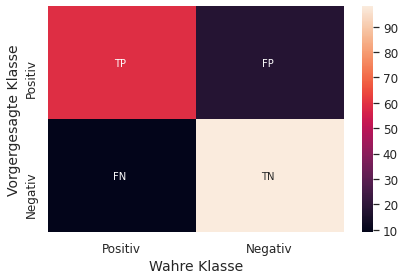

In [26]:
#plt.figure(figsize=(15,8))
tf_confusion_matrix2 =  confusion_matrix(y_test, tf_predicted)
ax = sns.heatmap(tf_confusion_matrix2, annot=True)
ax.set_xticklabels(('Positiv', 'Negativ'))
ax.set_yticklabels(('Positiv', 'Negativ'))
plt.xlabel('Wahre Klasse')
plt.ylabel('Vorgergesagte Klasse')
ax.texts[0].set_text('TP ' )
ax.texts[1].set_text('FP ')
ax.texts[2].set_text('FN ' )
ax.texts[3].set_text('TN ' )
save_fig("confusion_matrix_tf_no_vals")